In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Loading data...")
url = "http://lib.stat.cmu.edu/datasets/boston"
# FIXED: used r"\s+" to fix syntax warning
raw_df = pd.read_csv(url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X = data[:, [5, 0]] 
y = target.reshape(-1, 1)

print("Normalizing...")
mu, sig = X.mean(0), X.std(0)
X = (X - mu) / sig

# Normalize Target too for better convergence (Optional but recommended for regression)
ymu, ysig = y.mean(), y.std()
y = (y - ymu) / ysig

print("Splitting...")
n_tr = int(0.8 * len(X))
idx = np.random.permutation(len(X))
X_tr, X_te = X[idx[:n_tr]], X[idx[n_tr:]]
y_tr, y_te = y[idx[:n_tr]], y[idx[n_tr:]]
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

Loading data...
Normalizing...
Splitting...
Train: (404, 2), Test: (102, 2)


In [26]:
class NN:
    def __init__(self, ls, l2=0.0):
        # FIXED: He Initialization (Better for ReLU)
        self.W = [np.random.randn(ls[i], ls[i+1]) * np.sqrt(2/ls[i]) for i in range(len(ls)-1)]
        self.b = [np.zeros((1, ls[i+1])) for i in range(len(ls)-1)]
        self.l2 = l2
        
        # Optimizer states
        self.vW = [np.zeros_like(w) for w in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]
        self.mW = [np.zeros_like(w) for w in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.t = 0

    def relu(self, z): return np.maximum(0, z)
    def drelu(self, z): return (z > 0).astype(float)

    def fwd(self, x):
        self.A, self.Z = [x], []
        for i, (w, b) in enumerate(zip(self.W, self.b)):
            z = np.dot(self.A[-1], w) + b
            self.Z.append(z)
            self.A.append(self.relu(z) if i < len(self.W)-1 else z)
        return self.A[-1]

    def bwd(self, y, lr, opt, mu=0.9, b1=0.9, b2=0.999):
        m = y.shape[0]
        d = 2*(self.A[-1] - y)/m
        
        for i in range(len(self.W)-1, -1, -1):
            if i < len(self.W)-1: d = d * self.drelu(self.Z[i])
            
            dw = np.dot(self.A[i].T, d) + self.l2 * self.W[i]
            db = np.sum(d, axis=0, keepdims=True)
            
            # FIXED: Gradient Clipping to prevent explosion
            dw = np.clip(dw, -1.0, 1.0)
            db = np.clip(db, -1.0, 1.0)
            
            if opt == 'SGD':
                self.W[i] -= lr * dw
                self.b[i] -= lr * db
            elif opt == 'Mom':
                self.vW[i] = mu * self.vW[i] - lr * dw
                self.vb[i] = mu * self.vb[i] - lr * db
                self.W[i] += self.vW[i]
                self.b[i] += self.vb[i]
            elif opt == 'Adam':
                self.t += 1
                # Update weights
                self.mW[i] = b1 * self.mW[i] + (1-b1) * dw
                self.vW[i] = b2 * self.vW[i] + (1-b2) * (dw**2)
                mh_w = self.mW[i] / (1 - b1**self.t)
                vh_w = self.vW[i] / (1 - b2**self.t)
                self.W[i] -= lr * mh_w / (np.sqrt(vh_w) + 1e-8)
                
                # Update biases (Fixed logic)
                self.mb[i] = b1 * self.mb[i] + (1-b1) * db
                self.vb[i] = b2 * self.vb[i] + (1-b2) * (db**2)
                mh_b = self.mb[i] / (1 - b1**self.t)
                vh_b = self.vb[i] / (1 - b2**self.t)
                self.b[i] -= lr * mh_b / (np.sqrt(vh_b) + 1e-8)
                
            if i > 0: d = np.dot(d, self.W[i].T)

print("NN Class defined (Stable).")

NN Class defined (Stable).


Training SGD...
Training Mom...
Training Adam...


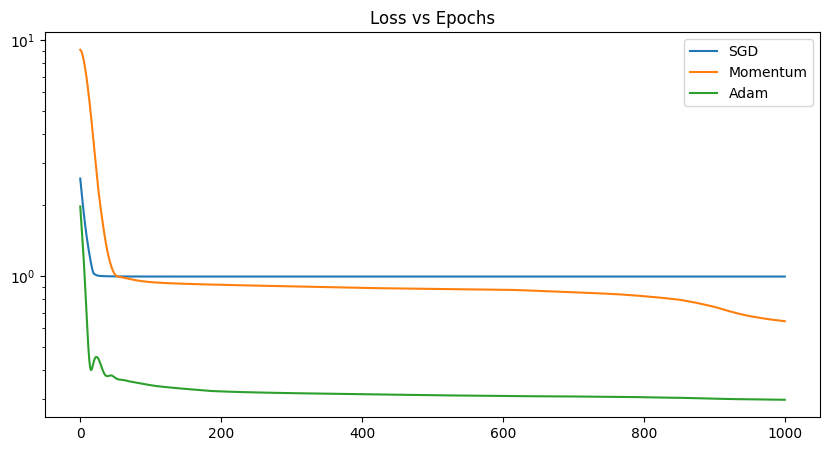

SGD Test MSE: 86.0559
Momentum Test MSE: 56.4262
Adam Test MSE: 17.7647


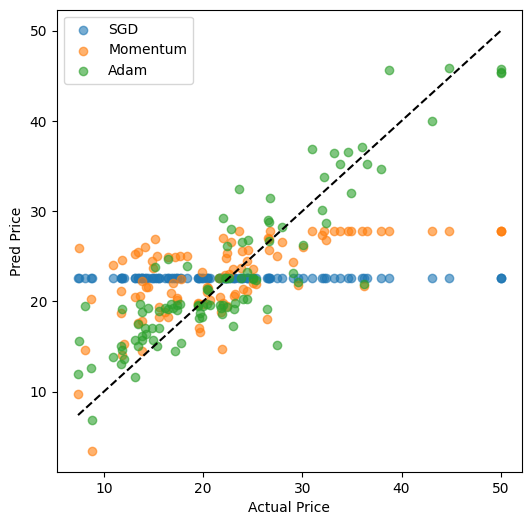

In [28]:
def run(opt, ls, lr=0.001, l2=0.0, ep=1000):
    print(f"Training {opt}...")
    m = NN(ls, l2)
    hist = []
    for i in range(ep):
        p = m.fwd(X_tr)
        loss = np.mean((y_tr - p)**2)
        m.bwd(y_tr, lr, opt)
        hist.append(loss)
    return m, hist

ls1 = [2, 5, 3, 1]
# Using lower LR to ensure stability
m_sgd, h_sgd = run('SGD', ls1, lr=0.01)
m_mom, h_mom = run('Mom', ls1, lr=0.001)
m_adam, h_adam = run('Adam', ls1, lr=0.01)

plt.figure(figsize=(10,5))
plt.plot(h_sgd, label='SGD')
plt.plot(h_mom, label='Momentum')
plt.plot(h_adam, label='Adam')
plt.yscale('log')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

def eval_m(m, name):
    p = m.fwd(X_te)
    # Denormalize for real MSE interpretation
    real_p = p * ysig + ymu
    real_y = y_te * ysig + ymu
    mse = np.mean((real_y - real_p)**2)
    print(f"{name} Test MSE: {mse:.4f}")
    plt.scatter(real_y, real_p, alpha=0.6, label=name)

plt.figure(figsize=(6,6))
eval_m(m_sgd, 'SGD')
eval_m(m_mom, 'Momentum')
eval_m(m_adam, 'Adam')
# Plot ideal line
min_v, max_v = y_te.min()*ysig+ymu, y_te.max()*ysig+ymu
plt.plot([min_v, max_v],[min_v, max_v],'k--')
plt.xlabel("Actual Price")
plt.ylabel("Pred Price")
plt.legend()
plt.show()

Running Bonus Tasks...
Training Adam...
Training Adam...


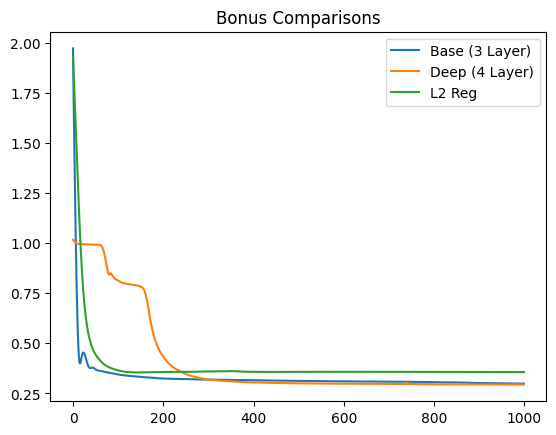

Deep Test MSE: 22.0392
Regularized Test MSE: 23.0009
Done.


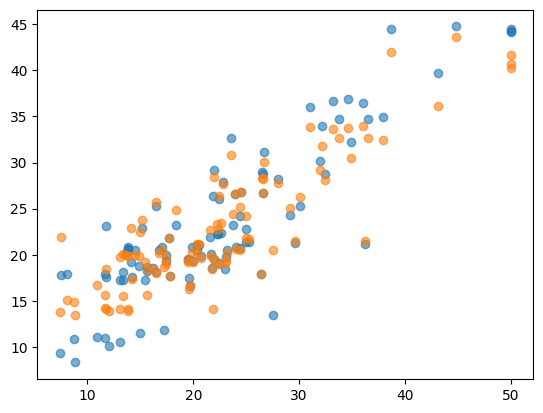

In [29]:
# Cell 4
print("Running Bonus Tasks...")

# Bonus 1: Extra Layer [2, 5, 3, 2, 1]
ls2 = [2, 5, 3, 2, 1]
m_deep, h_deep = run('Adam', ls2, lr=0.005)

# Bonus 2: L2 Reg
m_reg, h_reg = run('Adam', ls1, lr=0.005, l2=0.1)

plt.plot(h_adam, label='Base (3 Layer)')
plt.plot(h_deep, label='Deep (4 Layer)')
plt.plot(h_reg, label='L2 Reg')
plt.legend()
plt.title("Bonus Comparisons")
plt.show()

eval_m(m_deep, 'Deep')
eval_m(m_reg, 'Regularized')
print("Done.")